<a href="https://colab.research.google.com/github/petrum01/exts-aml3/blob/master/Convolutional_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import numpy as np


labels = np.load('/content/gdrive/My Drive/data/labels.npy')
pixels = np.load('/content/gdrive/My Drive/data/pixels.npy')

print('pixels', pixels.shape, type(pixels))
print('labels', labels.shape, type(labels) )


pixels (5000, 3072) <class 'numpy.ndarray'>
labels (5000,) <class 'numpy.ndarray'>


In [4]:
# Rescale pixel values between -0.5 and 0.5
# pixels = (pixels - 128) / 255
# this npy file is already rescaled
pixels

array([[0.49803922, 0.49803922, 0.49803922, ..., 0.11764706, 0.06666667,
        0.03137255],
       [0.31372549, 0.34509804, 0.32156863, ..., 0.69411765, 0.7254902 ,
        0.80784314],
       [0.24705882, 0.27843137, 0.30980392, ..., 0.51372549, 0.88627451,
        0.07843137],
       ...,
       [0.49411765, 0.49411765, 0.49411765, ..., 0.74117647, 0.72156863,
        0.72941176],
       [0.74117647, 0.74509804, 0.69411765, ..., 0.81176471, 0.83921569,
        0.72156863],
       [0.93333333, 0.9254902 , 0.98039216, ..., 0.09803922, 0.05490196,
        0.07058824]])

In [0]:
pixels = pixels.astype(np.float32)

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Split the matrix of pixels
X_tr, X_te, y_tr, y_te = train_test_split(pixels.reshape(-1, 32, 32, 3), # de-flatten the matrix of pixels
                                          labels, train_size=4000, test_size=1000, 
                                          stratify=labels, # same class distribution
                                          random_state=0)

print('Train:', X_tr.shape, y_tr.shape)
print('Test:', X_te.shape, y_te.shape)

X_tr2, X_val, y_tr2, y_val = train_test_split(X_tr, y_tr, train_size=3200, test_size=800, 
    stratify=y_tr , # same class distribution
    random_state=0)

print('Train2:', X_tr2.shape, y_tr2.shape)
print('Val:', X_val.shape, y_val.shape)

Train: (4000, 32, 32, 3) (4000,)
Test: (1000, 32, 32, 3) (1000,)
Train2: (3200, 32, 32, 3) (3200,)
Val: (800, 32, 32, 3) (800,)


In [0]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

In [8]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [9]:
# Create a CNN with the following architecture : 

# 1st Conv layer, 64 filters, 3x3 kernel size, stride 1x1, same pading, ReLu
# Max pooling layer 2x2, stride 2x2
# Dropout 0,25

# 2nd Conv layer, 128 filters, 3x3 kernel size, stride 1x1, same pading, ReLu
# Max pooling layer 2x2, stride 2x2
# Dropout 0,25

# 3rd Conv layer, 256 filters, 3x3 kernel size, stride 1x1, same pading, ReLu
# Max pooling layer 2x2, stride 2x2
# Dropout 0,5

# 3 fully connected layers : 256, 512, 256 hidden units, ReLu, 
# Dropout 0,5 after each fcl
# Output layer (4 units) with no activation function

import tensorflow as tf

# Create new graph
graph = tf.Graph()

with graph.as_default():
    # Create placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])

    # Convolutional layer
    conv = tf.layers.conv2d(
        X, # Input data
        filters=64, # 64 filters
        kernel_size=(3, 3), # Kernel size: 3x3
        strides=(1, 1), # Stride: 1
        padding='SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(
            stddev=0.01, seed=0), # Small standard deviation
        name='conv' 
    )
    print('Convolutional layer 1',conv.shape)
    
     # Max pooling layer
    pool = tf.layers.max_pooling2d(
        conv, # Convolution output
        pool_size=(2, 2), # Pool size: 2
        strides=(2, 2), # Stride: 2
        padding='SAME' # "same" padding
    )
    print('max pooling 1',pool.shape) 
    
        # Dropout
    training = tf.placeholder(dtype=tf.bool)
    pool = tf.layers.dropout(pool, rate=0.25, seed=0, training=training)
    print('max pooling 1 dropout',pool.shape)
    
     # Convolutional layer
    conv2 = tf.layers.conv2d(
        pool, 128, (3, 3), (1, 1), 'SAME',
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(
            stddev=0.01, seed=0), # Small standard deviation
        name='conv2' 
    )
    print('Convolutional layer 2',conv2.shape)

    # Max pooling layer (2x2, stride: 2)
    pool2 = tf.layers.max_pooling2d(conv2, (2, 2), (2, 2), 'SAME')
    print('max pooling 2',pool2.shape) 

        # Dropout
    pool2 = tf.layers.dropout(pool2, rate=0.25, seed=0, training=training)
    print('max pooling 2 dropout',pool2.shape)
    
    # Convolutional layer
    conv3 = tf.layers.conv2d(
        pool2, 256,(3, 3), (1, 1), 'SAME',
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(
            stddev=0.01, seed=0), # Small standard deviation
        name='conv3' 
    )
    print('Convolutional layer 3',conv3.shape)

    # Max pooling layer (2x2, stride: 2)
    pool3 = tf.layers.max_pooling2d(conv3, (2, 2), (2, 2), 'SAME')
    print('max pooling 3',pool3.shape) 
    
    # Flatten output
    flat_output = tf.contrib.layers.flatten(pool3)

    # Dropout
    flat_output = tf.layers.dropout(flat_output, rate=0.5, seed=0, training=training)
    print('Dropout:', flat_output.shape)

    # Fully connected layer
    fc1 = tf.layers.dense(
        flat_output, 256, # hidden units
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    print('Fully-connected layer1:', fc1.shape)
    
    # Dropout
    fc1 = tf.layers.dropout(fc1, rate=0.5, seed=0, training=training)
    print('Dropout:', fc1.shape)
    
    # Fully connected layer
    fc2 = tf.layers.dense(
        fc1, 512, # hidden units
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    print('Fully-connected layer2:', fc2.shape)
    
    # Dropout
    fc2 = tf.layers.dropout(fc2, rate=0.5, seed=0, training=training)
    print('Dropout:', fc2.shape)
    
    # Fully connected layer
    fc3 = tf.layers.dense(
        fc2, 256, # hidden units
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    print('Fully-connected layer3:', fc3.shape)
    
    # Dropout
    fc3 = tf.layers.dropout(fc3, rate=0.5, seed=0, training=training)
    print('Dropout:', fc3.shape)
    
    # Output layer
    logits = tf.layers.dense(
        fc3, 4, # 4 classes
        activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    print('Output layer',logits.shape) 

    # Get variables in the graph
    for v in tf.trainable_variables():
        print(v)
    
    # Kernel weights of the 1st conv. layer
    with tf.variable_scope('conv', reuse=True):
        conv_kernels = tf.get_variable('kernel')

        # Mean cross-entropy
    mean_ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))

    # Adam optimizer
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.AdamOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

Convolutional layer 1 (?, 32, 32, 64)
max pooling 1 (?, 16, 16, 64)
max pooling 1 dropout (?, 16, 16, 64)
Convolutional layer 2 (?, 16, 16, 128)
max pooling 2 (?, 8, 8, 128)
max pooling 2 dropout (?, 8, 8, 128)
Convolutional layer 3 (?, 8, 8, 256)
max pooling 3 (?, 4, 4, 256)
Dropout: (?, 4096)
Fully-connected layer1: (?, 256)
Dropout: (?, 256)
Fully-connected layer2: (?, 512)
Dropout: (?, 512)
Fully-connected layer3: (?, 256)
Dropout: (?, 256)
Output layer (?, 4)
<tf.Variable 'conv/kernel:0' shape=(3, 3, 3, 64) dtype=float32_ref>
<tf.Variable 'conv/bias:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'conv2/kernel:0' shape=(3, 3, 64, 128) dtype=float32_ref>
<tf.Variable 'conv2/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'conv3/kernel:0' shape=(3, 3, 128, 256) dtype=float32_ref>
<tf.Variable 'conv3/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'dense/kernel:0' shape=(4096, 256) dtype=float32_ref>
<tf.Variable 'dense/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'd

In [38]:
%%time
import numpy as np
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Set seed
    np.random.seed(0)
    
    # Train several epochs
    for epoch in range(300):
        # Accuracy values (train) after each batch
        batch_acc = []
        
        for X_batch, y_batch in get_batches(X_tr2, y_tr2, 250):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.0001, # Learning rate
                training: True #dropout
            })
            
            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_val,
            y: y_val,
            training: False
        })
        valid_acc_values.append(valid_acc)
        
        # Print progress
        if (epoch+1)%10==0 :
          print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))
       
    # Get 1st conv. layer kernels
    kernels = conv_kernels.eval()
    
    # Evaluate test accuracy
    test_acc = sess.run(accuracy, feed_dict={
        X: X_te,
        y: y_te,
            training: False
    })
    print('Test accuracy: {:.3f}'.format(test_acc))

Epoch 10 - valid: 0.377 train: 0.335 (mean)
Epoch 20 - valid: 0.474 train: 0.427 (mean)
Epoch 30 - valid: 0.501 train: 0.479 (mean)
Epoch 40 - valid: 0.549 train: 0.538 (mean)
Epoch 50 - valid: 0.590 train: 0.582 (mean)
Epoch 60 - valid: 0.606 train: 0.614 (mean)
Epoch 70 - valid: 0.624 train: 0.625 (mean)
Epoch 80 - valid: 0.635 train: 0.668 (mean)
Epoch 90 - valid: 0.656 train: 0.693 (mean)
Epoch 100 - valid: 0.654 train: 0.710 (mean)
Epoch 110 - valid: 0.702 train: 0.746 (mean)
Epoch 120 - valid: 0.725 train: 0.764 (mean)
Epoch 130 - valid: 0.731 train: 0.788 (mean)
Epoch 140 - valid: 0.734 train: 0.816 (mean)
Epoch 150 - valid: 0.734 train: 0.832 (mean)
Epoch 160 - valid: 0.749 train: 0.841 (mean)
Epoch 170 - valid: 0.746 train: 0.867 (mean)
Epoch 180 - valid: 0.760 train: 0.893 (mean)
Epoch 190 - valid: 0.724 train: 0.897 (mean)
Epoch 200 - valid: 0.731 train: 0.909 (mean)
Epoch 210 - valid: 0.751 train: 0.914 (mean)
Epoch 220 - valid: 0.755 train: 0.935 (mean)
Epoch 230 - valid: 

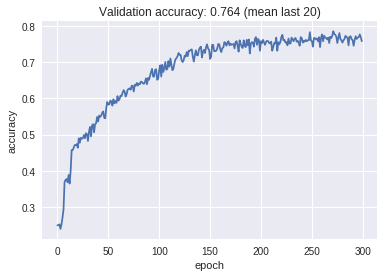

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)
plt.title('Validation accuracy: {:.3f} (mean last 20)'.format(
    np.mean(valid_acc_values[-20:]) # last 20 values
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [0]:
# epochs.  batch.  lr.      acc. 
# 100.      64.    0.0001   0.751
# 100.     128.    0.0001   0.726
# 100.     200.    0.0001   0.694
# 200.     200.    0.0001   0.747
# 400.     200.    0.0001   0.765
# 400.     250.    0.0001   0.773  ## Best result
# 300.     250.    0.0001   0.758

# 400.     300.    0.0001   0.763
# 400.     128.    0.0001   0.761
# 200.     128.    0.0001   0.751

# 300.     200.    0.001    0.556
# 600.     200.    0.001    0.607
# 600.      64.    0.0001    0.683
# 600.     200.    0.00001   0.612

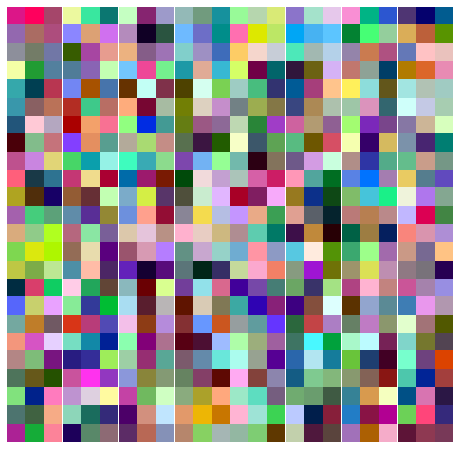

In [40]:
# Plot the trained weights of the kernels from the first convolutional layer.

# Create a grid of subplots
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(8, 8))

# Remove gaps between suplots
plt.subplots_adjust(wspace=0, hspace=0)

# Plot the 64 kernels from the first convolutional layer
for i, axis in enumerate(axes.flatten()):
    # Get i-th kernel (shape: 5x5x3)
    kernel = kernels[:, :, :, i].copy()
    
    # Rescale values between 0 and 1
    kernel -= kernel.min() # Rescale between 0 and max
    kernel /= kernel.max() # Rescale between 0 and 1
    
    # Plot kernel with imshow()
    axis.imshow(kernel)
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis
    
plt.show()